In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip /content/drive/MyDrive/7_faces.zip -d /content/
!pip install pytorch-lightning

In [4]:
from typing import Any
from tqdm.auto import tqdm
import numpy as np
import warnings
import pandas as pd
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import torchvision
from albumentations.pytorch import ToTensorV2
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image
import random
import matplotlib.pyplot as plt
import albumentations as A

In [13]:
train_transform = A.ReplayCompose([A.RandomResizedCrop(112, 112, scale = (0.85, 1.0)),
                                           A.ToRGB(),
                                           A.Normalize(),
                                           A.Rotate(limit=30, p = 0.5),
                                           A.HorizontalFlip(p = 0.5),
                                           A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
                                           ToTensorV2()],
                                    keypoint_params=A.KeypointParams(format='xy', remove_invisible = False))

val_transform = A.ReplayCompose([A.Resize(112, 112), A.ToRGB(), A.Normalize(), ToTensorV2()],
                                    keypoint_params=A.KeypointParams(format='xy', remove_invisible = False))

def vis(img_, gt_ = None):
    fig, ax = plt.subplots()
    plt.imshow(img_.permute(1, 2, 0).numpy())
    if gt_ is not None:
        ax.scatter(gt_.numpy()[::2], gt_[1::2].numpy())
        # text = [str(x) for x in range(1, 15)]
        # for i in range(14):
        #     ax.annotate(text[i], (gt_.numpy()[::2][i], gt_[1::2].numpy()[i]))
    plt.show()

class FacesGtDataset(Dataset):
    def __init__(self, imgs_path, gt_path_csv = None, transform = None, is_train = True, custom_len = None, filenames = None):
        super().__init__()
        self.imgs_path = imgs_path
        self.is_train = is_train
        self.custom_len = custom_len
        self.gt_path_csv = gt_path_csv
        if filenames is None:
            self.list_img_names = os.listdir(imgs_path)
        else:
            self.list_img_names = filenames
        self.transform = transform
        if self.gt_path_csv is not None:
            gt_csv = pd.read_csv(gt_path_csv)
            gt_path_to_list = gt_csv.set_index('filename').T.to_dict('list')
            self.path_to_gt = {path: list(zip(gts[::2], gts[1::2])) for path, gts in gt_path_to_list.items()}


    def __len__(self):
        if self.custom_len is None:
            return len(self.list_img_names)
        return self.custom_len


    def __getitem__(self, idx):
        img_name_ = self.list_img_names[idx]
        img_ = np.array(Image.open(os.path.join(self.imgs_path, img_name_)))
        if self.gt_path_csv is not None:
            gt_ = self.path_to_gt[img_name_]
            transformed_img_gt = self.transform(image=img_, keypoints=gt_)
            img_trans_, gt_trans_ =  transformed_img_gt['image'].float(), torch.tensor(transformed_img_gt['keypoints']).float()
            if self.is_train and transformed_img_gt['replay']['transforms'][4]['applied']:
                # vis(img_trans_, gt_trans_.reshape(-1))
                gt_trans_ = self.keypoints_horizontal_flip(gt_trans_)
            return img_trans_, gt_trans_.reshape(-1)
        n_rows, n_cols = img_.shape[0], img_.shape[1]
        transformed_img_ = self.transform(image=img_)
        return transformed_img_['image'], img_name_, n_rows, n_cols

    @staticmethod
    def keypoints_horizontal_flip(gt_):
        idxs = [3,2,1,0,9,8,7,6,5,4,10,13,12,11]
        return gt_[idxs]

class FacesGtDataloader(pl.LightningModule):
    def __init__(self, train_img_dir, train_gt, test_img_dir = None, test_gt = None):
        super().__init__()
        self.train_img_dir = train_img_dir
        self.train_gt = train_gt
        self.test_img_dir = test_img_dir
        self.test_gt = test_gt

    def train_dataloader(self):

        train_dataset = FacesGtDataset(self.train_img_dir, self.train_gt, transform=train_transform)
        return DataLoader(train_dataset, batch_size = 64, shuffle=True,  num_workers = 2)

    def val_dataloader(self):

        val_dataset = FacesGtDataset(self.test_img_dir, self.test_gt, transform= val_transform, is_train= False)
        return DataLoader(val_dataset, batch_size = 64,  num_workers = 2)

In [14]:
VAL_RATE = 0.2

class FacesTrainSplittingDataloader(pl.LightningModule):
    def __init__(self, img_dir, gt):
        super().__init__()
        self.img_dir = img_dir
        self.gt = gt
        images = os.listdir(img_dir)
        random.Random(42).shuffle(images)
        test_size = int(len(images) * VAL_RATE)
        self.test_filenames_ = images[:test_size]
        self.train_filenames_ = images[test_size:]

    def train_dataloader(self):
        train_dataset = FacesGtDataset(self.img_dir, self.gt, transform=train_transform, filenames = self.train_filenames_)
        return DataLoader(train_dataset, batch_size = 64, shuffle=True,  num_workers = 2)

    def val_dataloader(self):
        val_dataset = FacesGtDataset(self.img_dir, self.gt, transform= val_transform, filenames = self.test_filenames_, is_train= False)
        return DataLoader(val_dataset, batch_size = 64,  num_workers = 2)

In [15]:
class DetectionNN(nn.Sequential):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding = 'same')
        self.relu1 = nn.ReLU()
        self.conv1_bn = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(64, 128, 3, padding = 'same')
        self.relu2 = nn.ReLU()
        self.conv2_bn = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 128, 3, padding = 'same')
        self.relu3 = nn.ReLU()
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, padding = 'same')
        self.relu4 = nn.ReLU()
        self.conv4_bn = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.drop4 = nn.Dropout(0.2)

        self.conv5 = nn.Conv2d(256, 256, 3, padding = 'same')
        self.relu5 = nn.ReLU()
        self.conv5_bn = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.conv6 = nn.Conv2d(256, 512, 3, padding = 'same')
        self.relu6 = nn.ReLU()
        self.conv6_bn = nn.BatchNorm2d(512)
        self.pool6 = nn.MaxPool2d(2, 2)
        self.drop6 = nn.Dropout(0.2)

        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        self.fc1 = nn.Linear(512 * 7 * 7, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc2_bn = nn.BatchNorm1d(64)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 28)


def time_decay(step):
    k = 0.0001
    lrate = 1 / (1 + k * step)
    return lrate

class DetectionModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = DetectionNN()
        self.loss = nn.MSELoss()
        self.lr_rate = 1e-2

    def training_step(self, batch, batch_idx):
        imgs_, gts_ = batch
        y_pred = self.model(imgs_)
        loss = self.loss(gts_, y_pred)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs_, gts_ = batch
        y_pred = self.model(imgs_)
        loss = self.loss(gts_, y_pred)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate, weight_decay = 1e-4)

        lr_dict = {
            "scheduler": torch.optim.lr_scheduler.LambdaLR(
                optimizer,
                lr_lambda=time_decay,
            ),
            "interval": "step",
            "frequency": 1,
            "monitor": "train_loss",
            "strict": True,
            "name": None,
        }

        return [optimizer], [lr_dict]

In [18]:
def train_detector(train_gt, train_img_dir, fast_train = True, test_gt = None, test_img_dir = None):
    MyTrainingModuleCheckpoint = ModelCheckpoint(
        dirpath="runs/pl_classifier",
        filename="{epoch}-{val_loss:.3f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
    )

    trainer = pl.Trainer(
        max_epochs=100,
        accelerator="gpu",
        devices=1,
        callbacks=[MyTrainingModuleCheckpoint],
        default_root_dir ='./',
    )

    model = DetectionModule()
    if test_gt is None:
        faces_dataloader = FacesGtDataloader(train_img_dir, train_gt)
    else:
        faces_dataloader = FacesTrainSplittingDataloader(train_img_dir, train_gt)
    trainer.fit(model, datamodule= faces_dataloader)
    trainer.save_checkpoint('facepoints_model.ckpt')
    return model

@torch.no_grad()
def detect(model_filename, test_img_dir):
    model = DetectionModule.load_from_checkpoint(model_filename, map_location = 'cpu')
    model.eval()
    detect_transform = A.Compose([A.Resize(112, 112), A.ToRGB(), A.ToFloat(), ToTensorV2()])
    test_dataset = FacesGtDataset(test_img_dir, transform=detect_transform, custom_len = 100)
    test_dataloader = DataLoader(test_dataset, batch_size = 1)
    detected = {}
    buff_img_ = np.zeros((112, 112, 1), dtype=np.uint8)

    for img_, img_name_, n_row, n_col in tqdm(test_dataloader):
        gt_pred = model(img_)
        gt_pred = gt_pred.squeeze(0).tolist()
        gt_pred = list(zip(gt_pred[::2], gt_pred[1::2]))
        resize_transform = A.Compose([A.Resize(n_row.item(), n_col.item())], keypoint_params=A.KeypointParams(format='xy', remove_invisible = False))
        detected[img_name_[0]] = [x for x_y in resize_transform(image = buff_img_, keypoints = gt_pred)['keypoints'] for x in x_y]
    for i in range(20):
        img, name, n_row, n_col = test_dataset[i]
        img = A.Resize(n_row, n_col)(image = img.permute(1, 2, 0).numpy())['image']
        vis(torch.tensor(img).permute(2, 0, 1), torch.tensor(detected[name]))
    return detected

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_detector('./tests/00_test_img_input/train/gt.csv', './tests/00_test_img_input/train/images', True, './tests/00_test_img_input/train/gt.csv', './tests/00_test_img_input/train/images')

  0%|          | 0/100 [00:00<?, ?it/s]

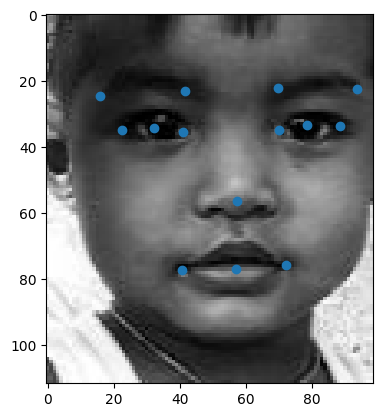

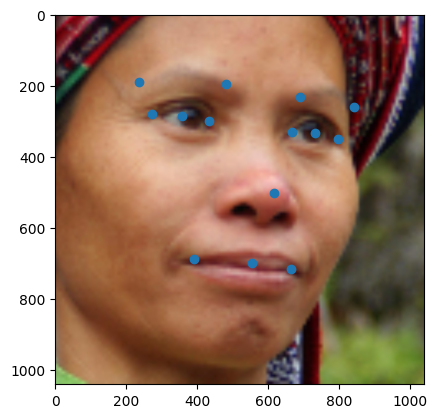

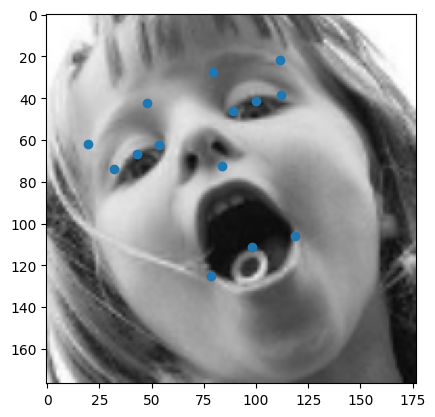

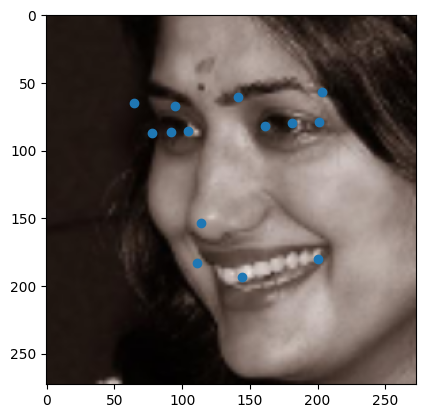

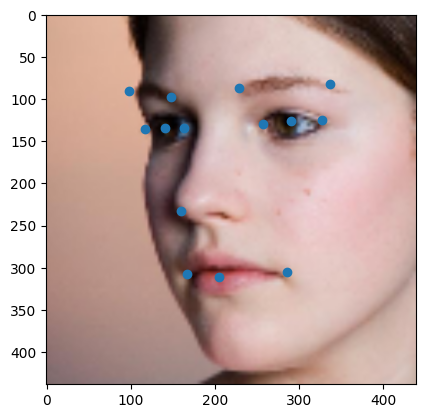

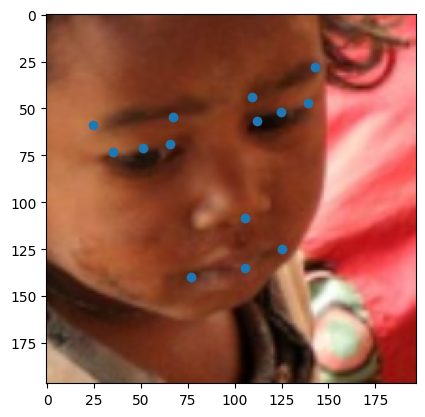

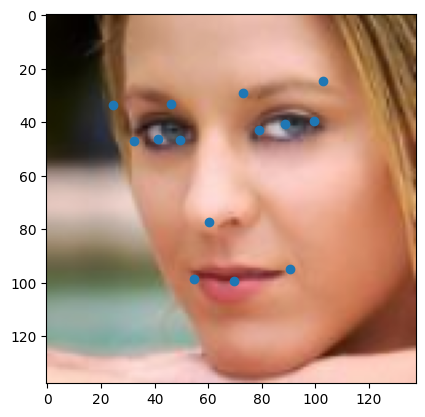

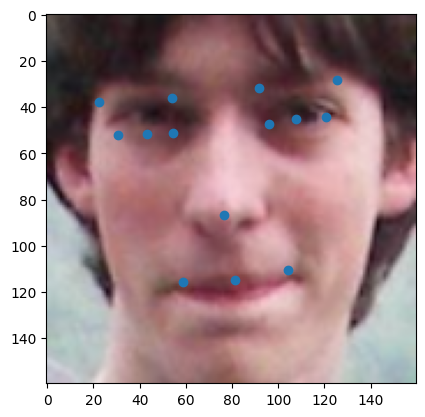

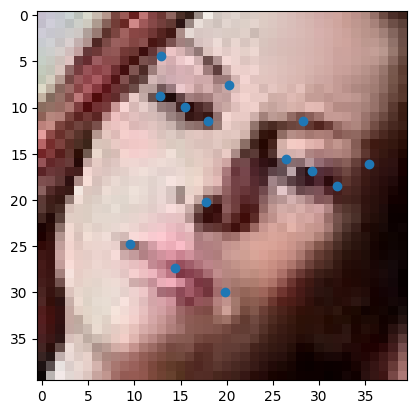

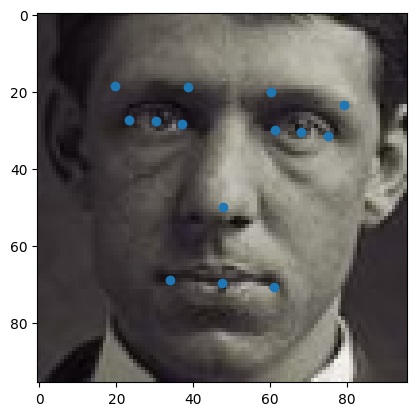

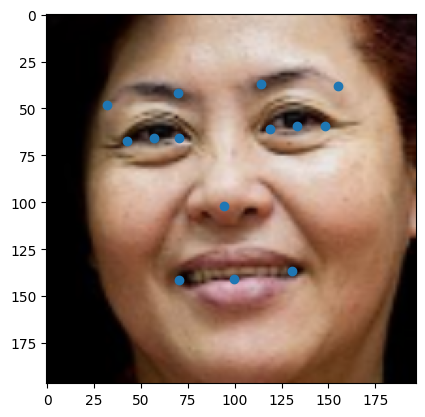

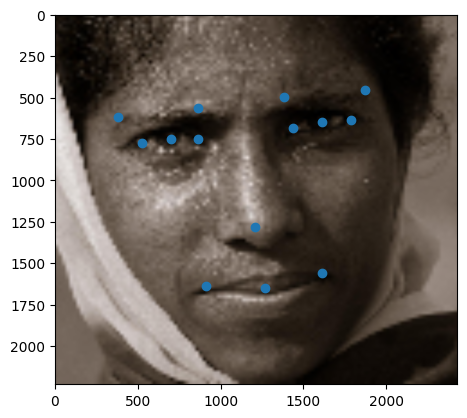

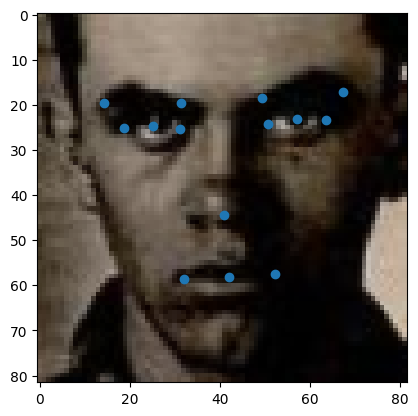

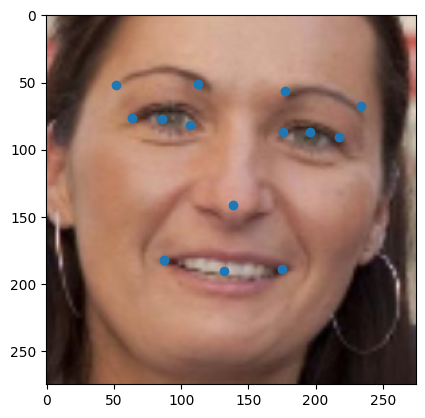

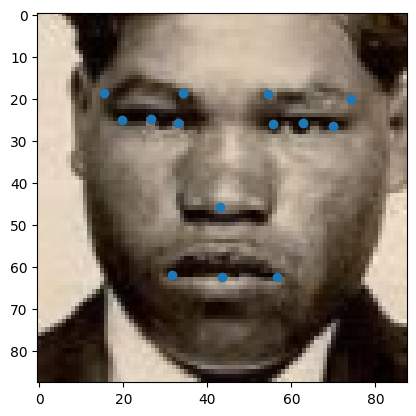

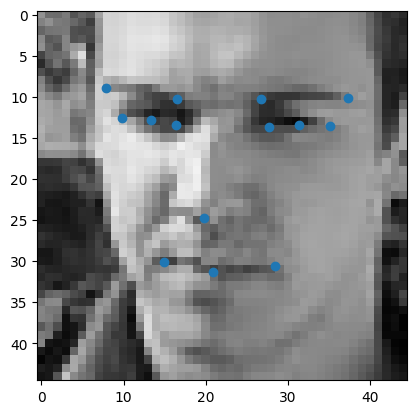

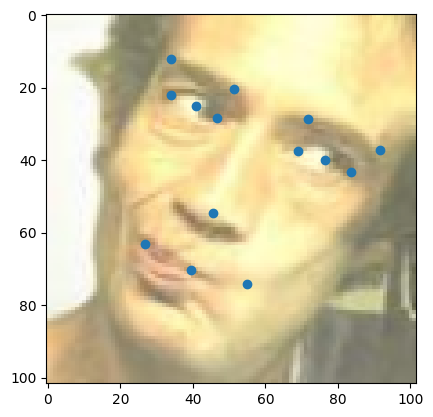

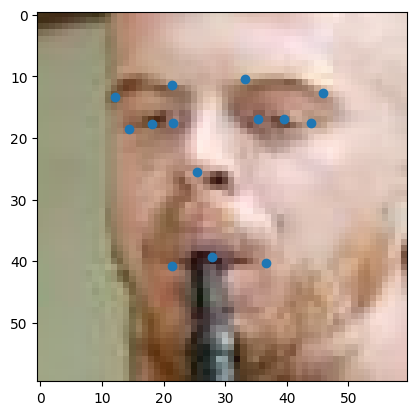

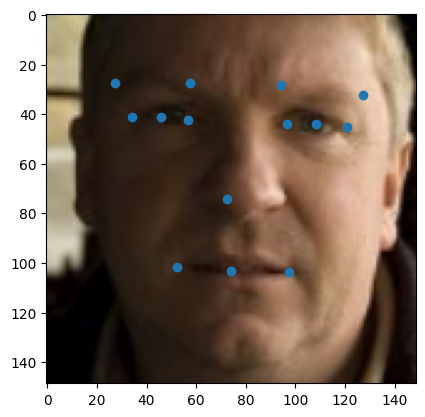

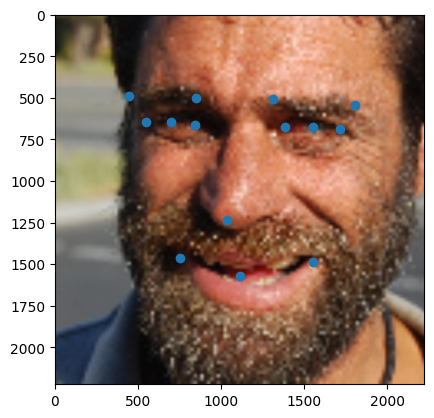

In [19]:
detected_gt = detect('facepoints_model.ckpt', './tests/00_test_img_input/test/images')